# Part 1 Code (ARIMA Forecast)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import itertools
import warnings
warnings.filterwarnings("ignore")

In [25]:
#LOAD AND CLEAN THE DATA
df = pd.read_csv('/content/oil_price.csv')
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Reindex to business days and interpolate
df = df.asfreq('B')
df['Price'] = df['Price'].interpolate(method='linear')

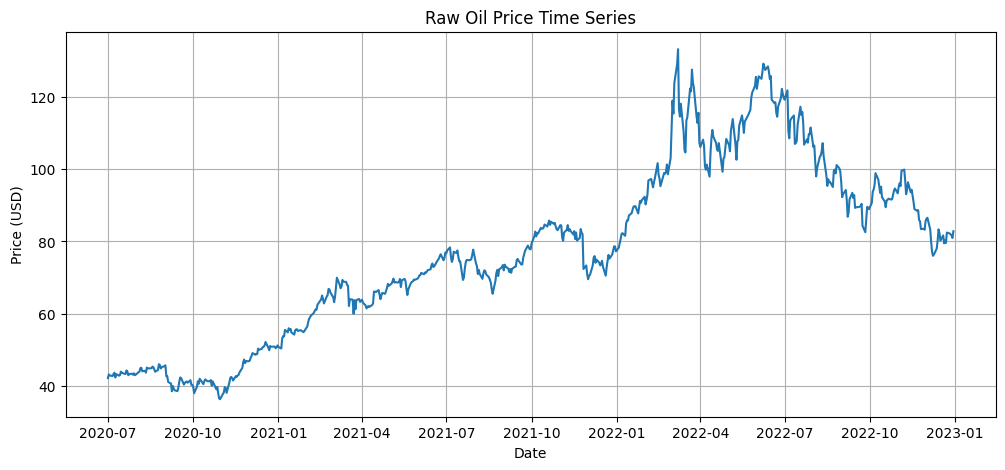

In [26]:
# PLOT RAW DATA
plt.figure(figsize=(12,5))
plt.plot(df['Price'])
plt.title("Raw Oil Price Time Series")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()


In [27]:
# STATIONARITY TEST (ADF)
def test_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Series is non-stationary.")
    else:
        print("Series is stationary.")

test_stationarity(df['Price'])


ADF Statistic: -1.666465502434471
p-value: 0.4484679715950124
Series is non-stationary.


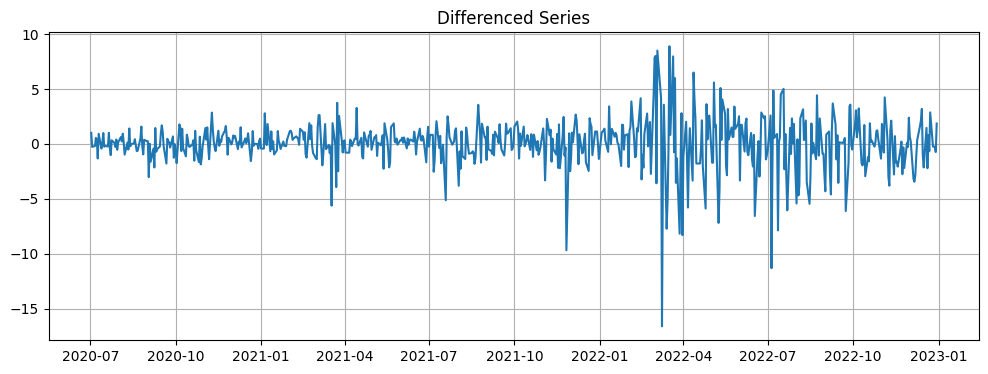

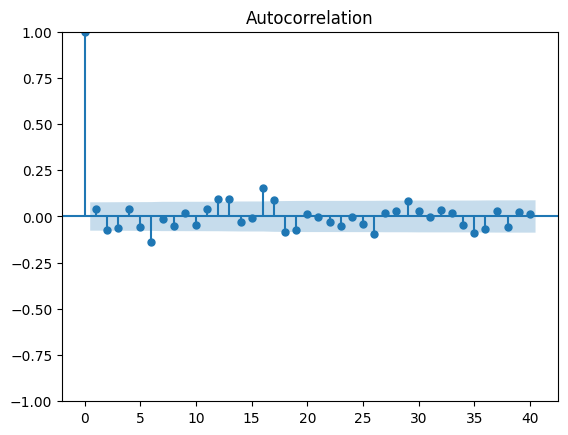

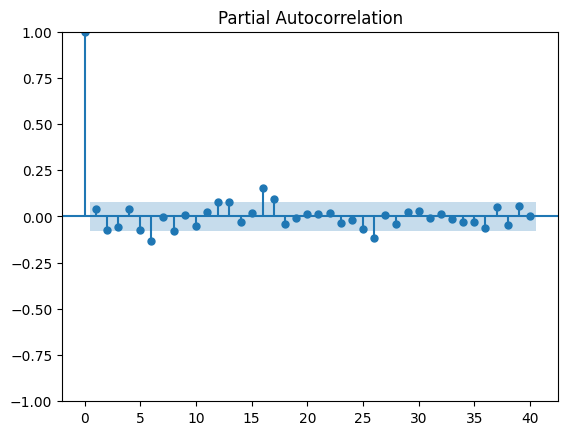

In [28]:
# DIFFERENCING (IF NON-STATIONARY)
df_diff = df['Price'].diff().dropna()

# Plot differenced data
plt.figure(figsize=(12,4))
plt.plot(df_diff)
plt.title("Differenced Series")
plt.grid(True)
plt.show()

# ACF and PACF
plot_acf(df_diff, lags=40)
plot_pacf(df_diff, lags=40)
plt.show()


In [29]:
# GRID SEARCH ARIMA(p,d,q) USING AIC
p_range = range(0, 4)
d_range = range(0, 3)
q_range = range(0, 4)
best_aic = float("inf")
best_order = None

for p, d, q in itertools.product(p_range, d_range, q_range):
    try:
        model = ARIMA(df['Price'], order=(p,d,q)).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = (p,d,q)
    except:
        continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")


Best ARIMA order: (2, 1, 2) with AIC: 2878.3231622615267


In [30]:
# FINAL ARIMA MODEL FITTING
model = ARIMA(df['Price'], order=best_order)
fitted_model = model.fit()
print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  653
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1434.162
Date:                Sun, 22 Jun 2025   AIC                           2878.323
Time:                        07:36:45   BIC                           2900.723
Sample:                    07-01-2020   HQIC                          2887.010
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0510      0.028      1.791      0.073      -0.005       0.107
ar.L2         -0.9531      0.025    -38.572      0.000      -1.002      -0.905
ma.L1         -0.0386      0.039     -0.994      0.3

In [34]:
# MODEL EVALUATION
residuals = fitted_model.resid
rmse = np.sqrt(mean_squared_error(df['Price'].iloc[-len(residuals):], fitted_model.fittedvalues))
print(f"RMSE on training data: {rmse:.2f}")


RMSE on training data: 2.74


In [35]:
import yfinance as yf

# Download historical oil price data from Yahoo Finance for 2023 and 2024
# 'CL=F' is the ticker symbol for Crude Oil Futures (WTI)
oil_data = yf.download('CL=F', start='2023-01-01', end='2025-01-01')

# Keeping only the 'Close' prices and renaming the column for consistency
oil_data = oil_data[['Close']].rename(columns={'Close': 'Actual_Price'})
oil_data.index.name = 'Date'

# Display basic info and head
oil_data.info(), oil_data.head()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2023-01-03 to 2024-12-31
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Actual_Price, CL=F)  502 non-null    float64
dtypes: float64(1)
memory usage: 7.8 KB


(None,
 Price      Actual_Price
 Ticker             CL=F
 Date                   
 2023-01-03    76.930000
 2023-01-04    72.839996
 2023-01-05    73.669998
 2023-01-06    73.769997
 2023-01-09    74.629997)

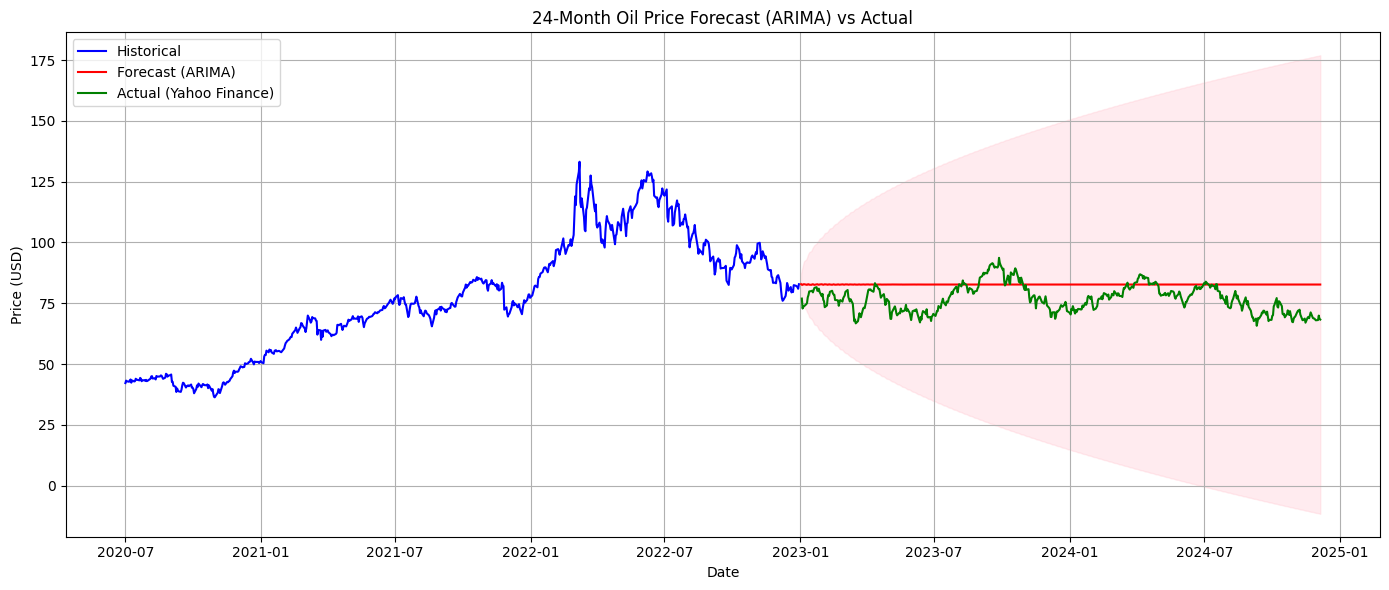

In [37]:
# 8. FORECAST 24 MONTHS (~504 business days)
forecast_steps = 504
forecast_result = fitted_model.get_forecast(steps=forecast_steps)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Align actual Yahoo data
actual_data = oil_data['Actual_Price']  # already downloaded via yfinance
actual_data = actual_data.asfreq('B').interpolate(method='linear')  # fill missing days
actual_data = actual_data.loc[forecast.index.min():forecast.index.max()]  # match date range

# Plot
plt.figure(figsize=(14,6))
plt.plot(df['Price'], label='Historical', color='blue')
plt.plot(forecast.index, forecast, label='Forecast (ARIMA)', color='red')
plt.fill_between(forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.plot(actual_data.index, actual_data, label='Actual (Yahoo Finance)', color='green')
plt.title('24-Month Oil Price Forecast (ARIMA) vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# part 2: Alternative Model Forecasting

In [38]:
!pip install prophet --quiet

In [41]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error

In [39]:
df = pd.read_csv('oil_price.csv')
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.asfreq('B')
df['Price'] = df['Price'].interpolate(method='linear')

# Prepare data for Prophet
prophet_df = df.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})

In [42]:
model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmppw1bqut6/kedn8q7_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppw1bqut6/q3s25dcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65372', 'data', 'file=/tmp/tmppw1bqut6/kedn8q7_.json', 'init=/tmp/tmppw1bqut6/q3s25dcl.json', 'output', 'file=/tmp/tmppw1bqut6/prophet_modelevwgxfg6/prophet_model-20250622074619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [43]:
future = model.make_future_dataframe(periods=730, freq='D')
forecast = model.predict(future)

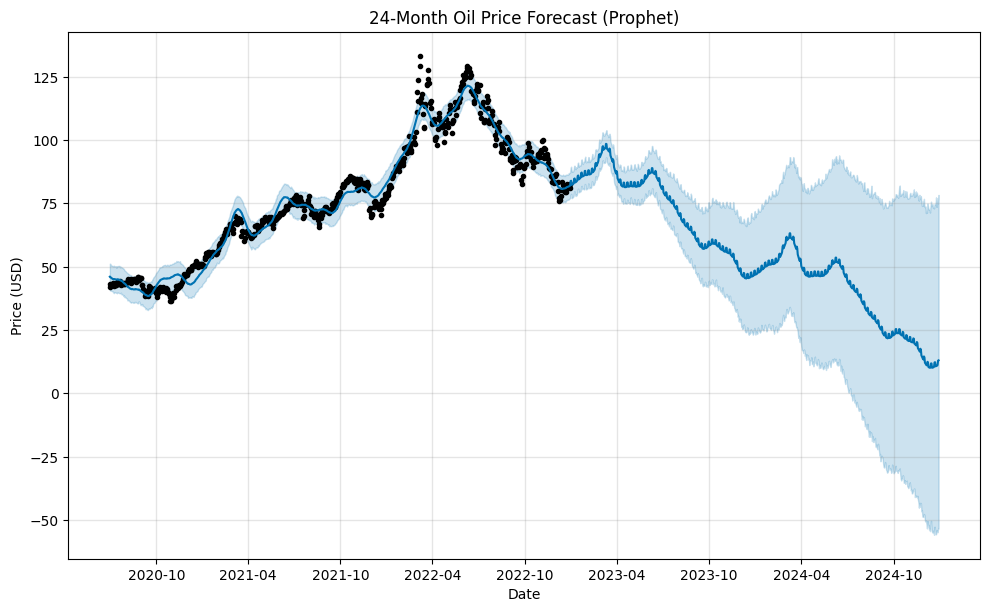

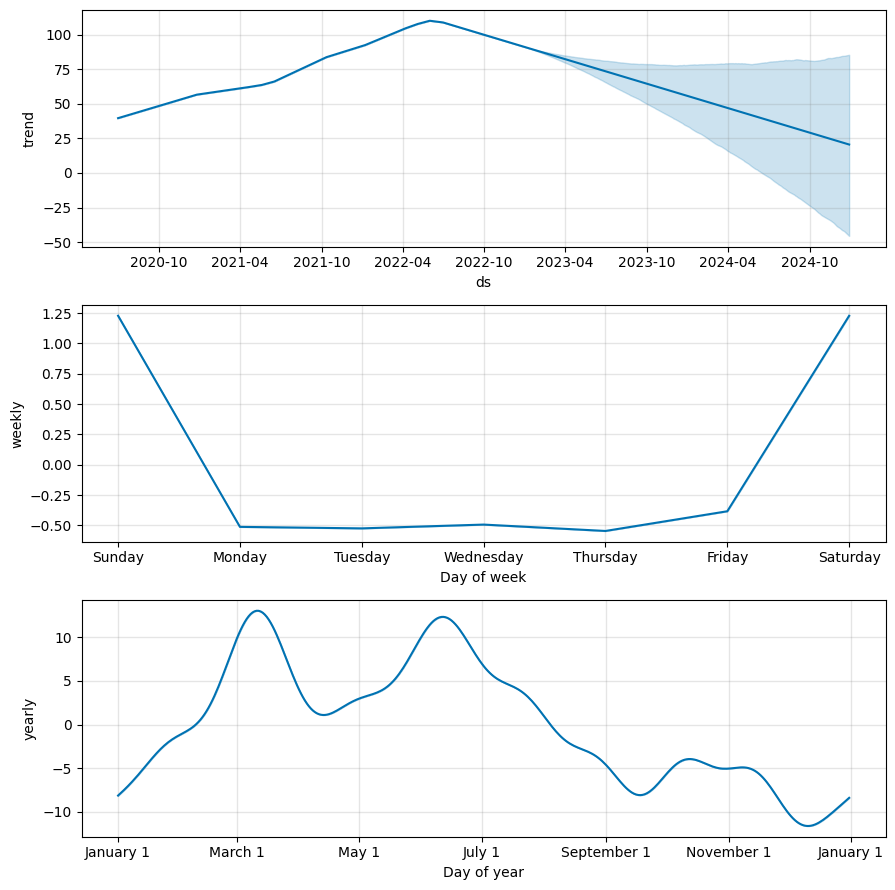

In [44]:
# Forecast plot
fig1 = model.plot(forecast)
plt.title("24-Month Oil Price Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

# Component plots (trend, weekly, yearly)
fig2 = model.plot_components(forecast)
plt.show()


In [45]:
# Merge actual and predicted for overlapping period
merged = pd.merge(prophet_df, forecast[['ds', 'yhat']], on='ds', how='inner')
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
print(f'Prophet RMSE on training data: {rmse:.2f}')

Prophet RMSE on training data: 4.04


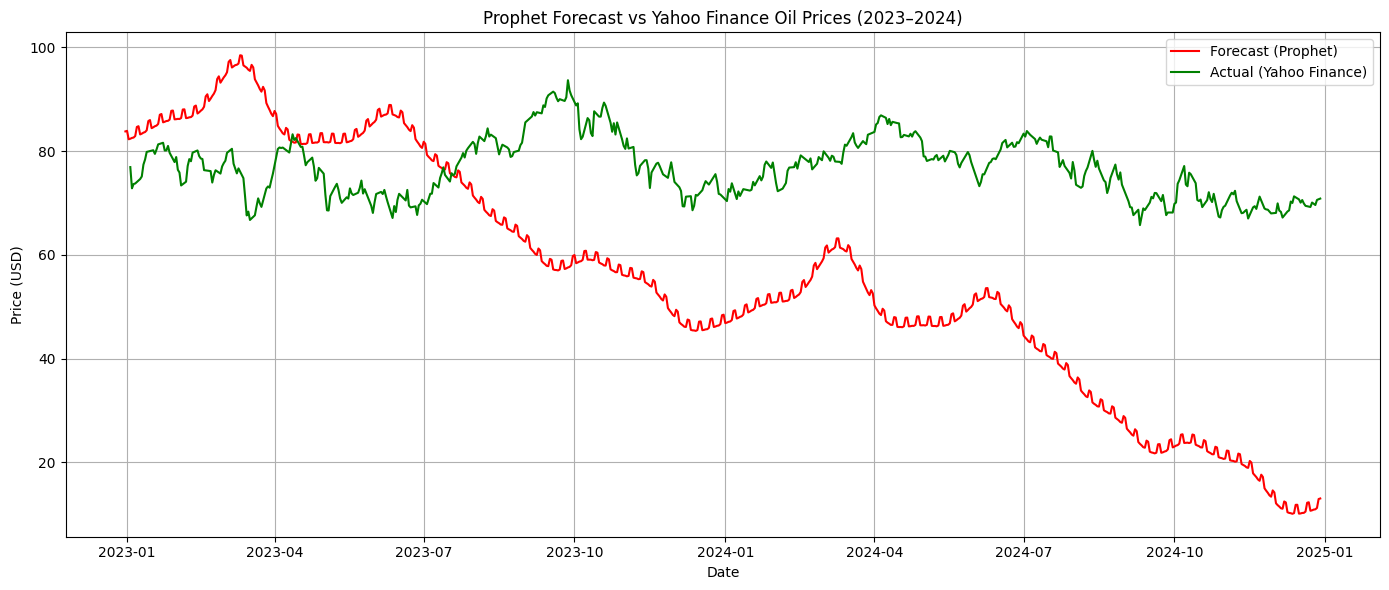

In [49]:
# Extract forecasted portion only (after training period)
last_train_date = prophet_df['ds'].max()
forecast_only = forecast[forecast['ds'] > last_train_date]

# Align actual Yahoo Finance data (2023–2024)
actual_data = oil_data['Actual_Price'].asfreq('D').interpolate(method='linear')
actual_data = actual_data[actual_data.index > last_train_date]
actual_data = actual_data.loc[forecast_only['ds'].min():forecast_only['ds'].max()]

# Merge for evaluation (optional)
comparison_df = pd.merge(forecast_only[['ds', 'yhat']], actual_data, left_on='ds', right_index=True, how='inner')

# Plot Prophet forecast vs Yahoo actual
plt.figure(figsize=(14, 6))
plt.plot(forecast_only['ds'], forecast_only['yhat'], label='Forecast (Prophet)', color='red')
plt.plot(actual_data.index, actual_data, label='Actual (Yahoo Finance)', color='green')
plt.title('Prophet Forecast vs Yahoo Finance Oil Prices (2023–2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()